# Дипломная работа "Анализ эмоциальной окраски текста"

#### Ячейка для Kaggel Kernel

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


## Задача 1 "Hate Speech and Offensive Language Dataset - research hate-speech detection"

Набор данных с использованием данных Twitter использовался для исследования обнаружения языка ненависти. Текст классифицируется как: разжигание ненависти, оскорбительные выражения и ни то, ни другое. В связи с характером исследования важно отметить, что этот набор данных содержит текст, который можно считать расистским, сексистским, гомофобным или вообще оскорбительным.


- count - количество пользователей CrowdFlower, которые закодировали каждый твит (минимум 3, иногда больше пользователей закодировали твит, когда CF определило суждения как ненадежные)
- hate_speech - количество пользователей CF, которые оценили твит как разжигание ненависти
- offensive_language	- количество пользователей CF, которые сочли твит оскорбительным
- neither	 - количество пользователей CF, которые сочли твит ни оскорбительным, ни не оскорбительным
- class(target) - метка класса для большинства пользователей CF. 
- - 0 – разжигание ненависти 
- - 1 – оскорбительные выражения 
- - 2 – ни то, ни другое
- tweet - текстовый твит

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import re
import string 
from string import punctuation
from nltk.corpus import stopwords
print(stopwords.words('english'))
NOISE_WORDS = stopwords.words('english')

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [2]:
import spacy
LEMMA = spacy.load('en_core_web_sm')

In [2]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.svm import SVC

from nltk import word_tokenize

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Загрузка данных (с нуля - далее по коду есть файл с обработанными данными, чтобы не ждать выполнения функции clean_text_for_Bert)

In [3]:
#../input/hate-speech-and-offensive-language-dataset/labeled_data.csv
df_1 = pd.read_csv('C:/Netology/DIPLOMA/data/hate/labeled_data.csv', index_col='Unnamed: 0')

In [8]:
df_1.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_1[df_1.hate_speech == 1]

,count,hate_speech,offensive_language,neither,class,tweet
5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."
14,3,1,2,0,1,""" bitch get up off me """
17,3,1,2,0,1,""" bitch who do you love """
49,3,1,2,0,1,""" these hoes like niggas that spend money not ..."
...,...,...,...,...,...,...
25262,3,1,2,0,1,yo hoe will get slayed! &#128298;
25265,6,1,5,0,1,you ain't a real nigga without goal a to chase...
25266,3,1,2,0,1,you ain't gotta be a dyke to like hoes
25275,3,1,2,0,1,"you got niggas, and i got bitches."


In [10]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


#### Распределение количества данных по классам

In [11]:
df_1[['class', 'tweet']].groupby('class').count()

,tweet
class,
0,1430
1,19190
2,4163


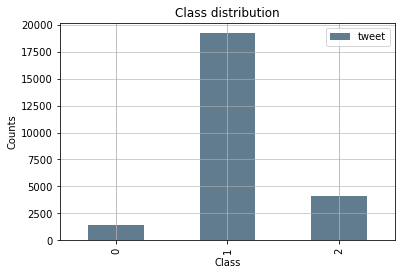

In [12]:
plot_1 = df_1[['class', 'tweet']].groupby('class').count()

plot_1.plot(kind='bar', grid = True,
                   color='#607c8e')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

###### Видно, что преобладают данные класса 1 - с оскорбительными выражениями


### Распределение по количеству пользователей CF, которые отнесли твит к тому или иному классу

In [13]:
df_1.groupby(['class']).sum()

,count,hate_speech,offensive_language,neither
class,,,,
0,4445,3227,1081,137
1,62730,3463,57638,1629
2,13208,262,1100,11846


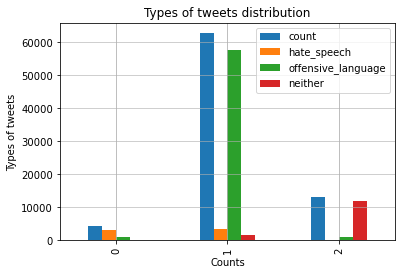

In [14]:
plot_2 = df_1.groupby(['class']).sum()

plot_2.plot(kind='bar', grid = True)
plt.title('Types of tweets distribution')
plt.xlabel('Counts')
plt.ylabel('Types of tweets')
plt.grid(axis='y', alpha=0.75)

###### Видно, что пользователи однозначно относят к верному классу твит, но в основном большинство на одной стороне

### Предобработка текста твитов

In [4]:
df_2 = pd.read_csv('df_2_task_1.csv', encoding='utf-8', index_col='Unnamed: 0')

In [5]:
df_2.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,rt woman should not complain clean house amp ...
1,3,0,3,0,1,rt boy dat cold tyga dwn bad cuffin dat hoe p...
2,3,0,3,0,1,rt dawg rt ever fuck bitch start cry confused...
3,3,0,2,1,1,rt look like tranny
4,6,0,6,0,1,rt shit hear might true might faker bitch tel...


In [6]:
# 4000 так как выше это понижение метрики f1 для 0 класса
df_2_0_2 = df_2[(df_2['class'] == 0) | (df_2['class'] == 2)]
df_2_1 = df_2[df_2['class'] == 1].sample(4000)
df_2 = pd.concat([df_2_0_2, df_2_1])

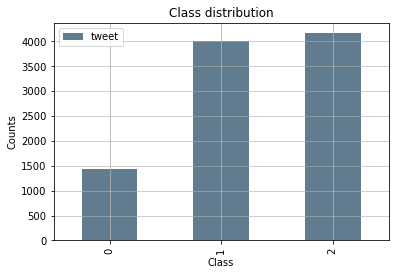

In [7]:
plot_1 = df_2[['class', 'tweet']].groupby('class').count()

plot_1.plot(kind='bar', grid = True,
                   color='#607c8e')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_2['tweet'], df_2['class'], test_size = 0.2)

# ++

## Первый способ - CountVectorizer('word', ngram = 1-1) + LogisticRegression

In [18]:
vec = CountVectorizer( ngram_range=(1, 1))
vec.fit(df_2['tweet'])
bow = vec.transform(X_train)

In [19]:
clf = LogisticRegression(random_state=42, solver='liblinear', class_weight = 'balanced')
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(X_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       254
           1       0.86      0.88      0.87       788
           2       0.96      0.90      0.93       877

    accuracy                           0.86      1919
   macro avg       0.80      0.81      0.81      1919
weighted avg       0.87      0.86      0.86      1919



## Десятый способ - SMOTE + CountVectorizer + SVC

In [20]:
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(df_2['tweet'], df_2['class'], test_size = 0.2)

In [21]:
vec_10 = CountVectorizer( ngram_range=(1, 1))
vec_10.fit(df_2['tweet'])
bow_10 = vec_10.transform(X_train_10)

## Дисбаланс классов - SMOTE - Synthetic Minority Oversampling Techniques

In [34]:
from imblearn.over_sampling import SMOTE

In [23]:
sm = SMOTE (#sampling_strategy = 0.9,
        random_state=0,
        k_neighbors=4)
X_train_res, y_train_res = sm.fit_resample(bow_10, y_train_10)

In [24]:
print('\t\tДО балансировки \tПОСЛЕ балансировки ')
print('класс 2 : \t{}\t\t\t{}'.format(sum(y_train_10==2), sum(y_train_res==2)))
print('класс 1 : \t{}\t\t\t{}'.format(sum(y_train_10==1), sum(y_train_res==1)))
print('класс 0 : \t{}\t\t\t{}'.format(sum(y_train_10==0), sum(y_train_res==0)))
print('y :\t\t{}\t\t{}'.format(y_train_10.shape, y_train_res.shape))
print('X :\t\t{}\t\t{}'.format(bow_10.shape, X_train_res.shape))

		ДО балансировки 	ПОСЛЕ балансировки 
класс 2 : 	3340			3340
класс 1 : 	3208			3340
класс 0 : 	1126			3340
y :		(7674,)		(10020,)
X :		(7674, 11729)		(10020, 11729)


In [28]:
model_10 = SVC(gamma='auto')
model_10.fit(X_train_res, y_train_res)
pred_10 = model_10.predict(vec_10.transform(X_test_10))
print(classification_report(pred_10, y_test_10))

              precision    recall  f1-score   support

           0       0.69      0.24      0.36       878
           1       0.04      0.89      0.07        35
           2       0.80      0.65      0.72      1006

    accuracy                           0.47      1919
   macro avg       0.51      0.59      0.38      1919
weighted avg       0.74      0.47      0.54      1919



## Одиннадцатый способ - слои BERT + LogReg

In [4]:
import transformers as ppb

In [5]:
# For DistilBERT:
model_class_11, tokenizer_class_11, pretrained_weights_11 = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# ## Want BERT instead of distilBERT? Uncomment the following line:
# model_class_11, tokenizer_class_11, pretrained_weights_11 = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer_11 = tokenizer_class_11.from_pretrained(pretrained_weights_11)
model_11 = model_class_11.from_pretrained(pretrained_weights_11)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def clean_text_for_BERT(text):
    '''Функция на вход получает текст, на выходе выдаёт очищенный текст для BERT'''
    
    text = re.sub("@[\w'._+-:]+", 'USER_NAME_TAG', text) # второй шаг - убираем ники пользователей твитера, т.к. обычно не несут никакой окраски
    text = re.sub('https?://\S+|www\.\S+', 'URL_TAG', text) # третий шаг - убираем ссылки в твитах, т.к. названия ссылок  обычно не влияют на тональность 

    return text

In [7]:
df_11 = df_1.copy()

In [8]:
df_11['tweet'] = df_11['tweet'].apply(clean_text_for_BERT)

In [9]:
# df_11 = pd.read_csv('df_2_task_1.csv', encoding='utf-8', index_col='Unnamed: 0')

In [10]:
df_11 = df_11.drop(columns=['count','hate_speech', 'offensive_language', 'neither'])

In [11]:
df_11.head()

,class,tweet
0,2,!!! RT USER_NAME_TAG As a woman you shouldn't ...
1,1,!!!!! RT USER_NAME_TAG boy dats cold...tyga dw...
2,1,!!!!!!! RT USER_NAME_TAG Dawg!!!! RT USER_NAME...
3,1,!!!!!!!!! RT USER_NAME_TAG USER_NAME_TAG she l...
4,1,!!!!!!!!!!!!! RT USER_NAME_TAG The shit you he...


In [12]:
#токенизация
tokenized = df_11['tweet'].apply(lambda x: tokenizer_11.encode(x, add_special_tokens=True))

In [13]:
#padding - Выравниваем предложения по длине с помощью нулевых токенов.

# находим самое длинное предложение
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# заполняем обучающие данные, где не хватает длины до максимума -- добавляем нули
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [14]:
np.array(padded).shape

(24783, 479)

In [15]:
padded[0]

array([  101,   999,   999,   999, 19387,  5310,  1035,  2171,  1035,
        6415,  2004,  1037,  2450,  2017,  5807,  1005,  1056, 17612,
        2055,  9344,  2039,  2115,  2160,  1012,  1004, 23713,  1025,
        2004,  1037,  2158,  2017,  2323,  2467,  2202,  1996, 11669,
        2041,  1012,  1012,  1012,   102,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [16]:
#Masking - Теперь создаём отдельную переменную, чтобы сказать берту, что надо игнорировать паддинг при подсчёте attention.
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
import torch

In [19]:
#Используем BERT-model() прогоняет предложения через BERT
# повысить если Kaggle-Kernel
input_ids = torch.tensor(padded[:1000])  
attention_mask = torch.tensor(attention_mask[:1000])

with torch.no_grad():
    last_hidden_states = model_11(input_ids, attention_mask=attention_mask)

C:\Users\D683~1\AppData\Local\Temp/ipykernel_7084/1703350870.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask[:1000])


In [20]:
features = last_hidden_states[0][:,0,:].numpy()

In [21]:
features

array([[-0.01853382, -0.05220667,  0.05905863, ..., -0.12232067,
         0.20900404,  0.4365031 ],
       [-0.27208817,  0.09054741,  0.11396429, ..., -0.15788054,
         0.43918195,  0.4675711 ],
       [ 0.05119757,  0.14024201,  0.0734151 , ..., -0.30908403,
         0.42747226,  0.2912435 ],
       ...,
       [-0.02615643, -0.06772915,  0.03091111, ...,  0.22787833,
         0.3997597 ,  0.25893313],
       [-0.5325556 , -0.2915119 , -0.0599588 , ...,  0.09136757,
         0.07455762,  0.4762268 ],
       [-0.39163068, -0.12098335, -0.04429083, ..., -0.13627703,
         0.20316641,  0.4516092 ]], dtype=float32)

In [22]:
features.shape

(1000, 768)

In [23]:
labels = df_11['class'][:1000]

In [24]:
labels.unique()

array([2, 1, 0], dtype=int64)

<AxesSubplot:>

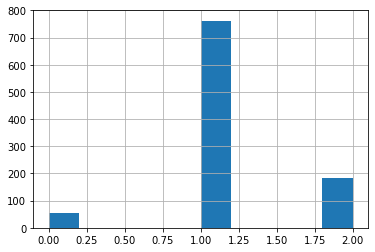

In [25]:
labels.hist()

In [26]:
labels.shape

(1000,)

In [38]:
#LogReg на признаках из BERT
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size=0.35)

In [39]:
sm = SMOTE (#sampling_strategy = 0.9,
        random_state=0,
        k_neighbors=4)
X_train_res, y_train_res = sm.fit_resample(train_features, train_labels)

## текст обработанный как и в других способах -3000

In [77]:
lr_clf_11 = LogisticRegression(class_weight = 'balanced')
lr_clf_11.fit(train_features, train_labels)
print(classification_report(lr_clf_11.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.53      0.24      0.33       171
           1       0.76      0.94      0.84       604
           2       0.78      0.60      0.68       225

    accuracy                           0.74      1000
   macro avg       0.69      0.59      0.61      1000
weighted avg       0.72      0.74      0.71      1000



C:\conda2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## текст обработанный для Berta - 1000

In [28]:
lr_clf_11 = LogisticRegression(class_weight = 'balanced')
lr_clf_11.fit(train_features, train_labels)
print(classification_report(lr_clf_11.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.45      0.36      0.40        14
           1       0.86      0.93      0.89       145
           2       0.72      0.56      0.63        41

    accuracy                           0.81       200
   macro avg       0.68      0.62      0.64       200
weighted avg       0.80      0.81      0.81       200



C:\conda2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## текст обработанный для Berta - 1000 - 0,2 + SMOTE

In [36]:
lr_clf_11 = LogisticRegression(class_weight = 'balanced')
lr_clf_11.fit(X_train_res, y_train_res)
print(classification_report(lr_clf_11.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.39      0.39      0.39        18
           1       0.86      0.88      0.87       137
           2       0.72      0.69      0.70        45

    accuracy                           0.79       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.79      0.79      0.79       200



C:\conda2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## текст обработанный для Berta - 1000 - 0,35 + SMOTE

In [40]:
lr_clf_11 = LogisticRegression(class_weight = 'balanced')
lr_clf_11.fit(X_train_res, y_train_res)
print(classification_report(lr_clf_11.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.33      0.40      0.36        20
           1       0.89      0.90      0.89       259
           2       0.69      0.61      0.65        71

    accuracy                           0.81       350
   macro avg       0.64      0.64      0.64       350
weighted avg       0.82      0.81      0.81       350



C:\conda2\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Двенадцатый способ - взять с BERTа и обучить SVC

## текст обработанный как и в других способах - 3000

In [78]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(train_features, train_labels)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.55      0.23      0.32       189
           1       0.72      0.94      0.82       575
           2       0.79      0.58      0.67       236

    accuracy                           0.72      1000
   macro avg       0.69      0.58      0.60      1000
weighted avg       0.71      0.72      0.69      1000



## текст обработанный для Berta - 1000 - 0.2 для теста

In [29]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(train_features, train_labels)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.36      0.13      0.20        30
           1       0.76      0.94      0.84       126
           2       0.66      0.48      0.55        44

    accuracy                           0.72       200
   macro avg       0.59      0.52      0.53       200
weighted avg       0.68      0.72      0.68       200



## текст обработанный для Berta - 1000 - 0.35 для теста

In [32]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(train_features, train_labels)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.57      0.15      0.24        52
           1       0.77      0.96      0.85       221
           2       0.72      0.56      0.63        77

    accuracy                           0.75       350
   macro avg       0.69      0.56      0.57       350
weighted avg       0.73      0.75      0.71       350



## текст обработанный для Berta - 1000 - 0,2 + SMOTE

In [37]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(X_train_res, y_train_res)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.61      0.38      0.47        29
           1       0.81      0.94      0.87       119
           2       0.77      0.63      0.69        52

    accuracy                           0.78       200
   macro avg       0.73      0.65      0.68       200
weighted avg       0.77      0.78      0.77       200



## текст обработанный для Berta - 1000 - 0,35 + SMOTE

In [41]:
lr_clf_12 = SVC(class_weight = 'balanced')
lr_clf_12.fit(X_train_res, y_train_res)
print(classification_report(lr_clf_12.predict(test_features), test_labels))

              precision    recall  f1-score   support

           0       0.54      0.30      0.39        43
           1       0.80      0.94      0.86       223
           2       0.73      0.54      0.62        84

    accuracy                           0.77       350
   macro avg       0.69      0.59      0.62       350
weighted avg       0.75      0.77      0.75       350

